In [57]:
import psycopg2
from decouple import config

!. ../.env

conn = psycopg2.connect("postgres://" + config("POSTGRES_USERNAME") + ":" + config("POSTGRES_PASSWORD") + "@raja.db.elephantsql.com:5432/mozfsrjp")
curs = conn.cursor()

In [ ]:
curs.close()
conn.commit()

### Define Functions for Analyzing Sentiment

In [3]:
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def escape_string(text):
    if isinstance(text, str):
        text = re.sub(r"\"", "\\\"", text)
        text = re.sub(r"'", "\\'", text)
        return text
    else:
        return "-"

def convert_int(x):
    try:
        return int(x)
    except:
        return -1

def get_saltiness(x):
    if isinstance(x, str):
        res = analyzer.polarity_scores(x)["neg"]
        return res
    return 0.0

In [4]:
def refine(df):
    
    df = df.loc[df['type'] == 'comment']
    df = df.loc[df['author'].isnull() == False]
    df = df[['id', 'time', 'author', 'parent', 'text', 'type']]
    df['parent'] = df['parent'].astype(int)    
    return df

def scrub(doc):
    patt = {
            "unicode_patt": "&.{4}(?=;);",
            "line_break":   "<p>",
            "href_patt":    "<a.*</a>",
            "quote":        "&quot;",
            "html_footnote": "\[.\]",
            "punctuation":   "[^\w\s]",
            "numbers":       "[^A-Za-z\s]",
        }
    
    r = rf'|'.join(patt.values())
    return re.sub(r, ' ', str(doc))

def process_text(df):
    
    # regex
    df['processed_text'] = df['text'].apply(scrub)
    # lowercase
    df['processed_text'] = df['processed_text'].str.lower()
    # double spaces
    df['processed_text'] = df['processed_text'].str.replace(r'\s+', ' ')
    
    
    # word freq
    word_freq = pd.Series(' '.join(df['processed_text']).split()).value_counts()
    
    common = list(word_freq[:10].index)
    rare = list(word_freq[word_freq.values < 2].index)
    
    stop_words = list(nltk.corpus.stopwords.words('english'))    
    stop_words = set(stop_words + common + rare)
    
    print('removing stopwords')
    pat = r'\b(?:{})\b'.format('|'.join(stop_words))
    
    df['no_stopwords'] = df['processed_text'].str.replace(pat, '')
    df['no_stopwords'] = df['no_stopwords'].str.replace(r'\s+', ' ')
    
    # remove less than 2 words
    df = df[df["no_stopwords"].str.split(" ").apply(lambda x: len(x)) > 3]
    
    return df

### Load CSV

In [5]:
import pandas as pd

hn_df = pd.read_csv("../csv/most_recent_1_5mm.csv")

In [7]:
top_1000 = hn_df["author"].value_counts().index[:1000]
hn_df = hn_df[hn_df["author"].isin(top_1000)]

In [15]:
from psycopg2.extras import execute_batch
import numpy as np
import nltk

batchsize = 10000

for ix in range(1040000, len(hn_df)+1, batchsize):
    
    print(f"Batch {ix} / {len(hn_df)} -- {ix/len(hn_df)*100:.2f}%")
    
    batch = hn_df[ix:ix+batchsize]
    batch = process_text(batch)
    
    batch = [
        [
            row[1][1],
            row[1][2],
            row[1][3],
            row[1][4],
            convert_int(row[1][7]),
            get_saltiness(row[1][4]),
        ]
        for row in batch.iterrows()
    ]
    
    batch = [
        row for row in batch if row[-1] < 1.0
    ]
    
    query = """
        INSERT INTO comments (id, author, time, comment_text, parent_id, saltiness)
        VALUES (%s, %s, %s, %s, %s, %s);
    """
    
    curs = conn.cursor()
    execute_batch(curs, query, batch)
    curs.close()

Batch 1040000 / 1499356 -- 69.36%


/home/cowley/venv/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/cowley/venv/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/cowley/venv/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

removing stopwords


/home/cowley/venv/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/cowley/venv/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Batch 1050000 / 1499356 -- 70.03%
removing stopwords
Batch 1060000 / 1499356 -- 70.70%
removing stopwords
Batch 1070000 / 1499356 -- 71.36%
removing stopwords
Batch 1080000 / 1499356 -- 72.03%
removing stopwords
Batch 1090000 / 1499356 -- 72.70%
removing stopwords
Batch 1100000 / 1499356 -- 73.36%
removing stopwords
Batch 1110000 / 1499356 -- 74.03%
removing stopwords
Batch 1120000 / 1499356 -- 74.70%
removing stopwords
Batch 1130000 / 1499356 -- 75.37%
removing stopwords
Batch 1140000 / 1499356 -- 76.03%
removing stopwords
Batch 1150000 / 1499356 -- 76.70%
removing stopwords
Batch 1160000 / 1499356 -- 77.37%
removing stopwords
Batch 1170000 / 1499356 -- 78.03%
removing stopwords
Batch 1180000 / 1499356 -- 78.70%
removing stopwords
Batch 1190000 / 1499356 -- 79.37%
removing stopwords
Batch 1200000 / 1499356 -- 80.03%
removing stopwords
Batch 1210000 / 1499356 -- 80.70%
removing stopwords
Batch 1220000 / 1499356 -- 81.37%
removing stopwords
Batch 1230000 / 1499356 -- 82.04%
removing sto

In [16]:
conn.commit()

In [17]:
query = """
    SELECT *
    FROM comments
    LIMIT 1000
"""
curs = conn.cursor()
curs.execute(query)
res = curs.fetchall()

In [ ]:
res[0]

In [59]:
res[3]

(22310905,
 'apta',
 1581529723,
 'Ah yes, the alcohol excuse. Who would have thought that allowing alcohol on flights wasn&#x27;t the best idea?',
 22309335,
 0.0)

In [28]:
from datetime import datetime, timedelta

hn_df["time_dt"] = hn_df["time"].apply(datetime.utcfromtimestamp)

In [32]:
three_months_ago = (datetime.utcnow() - timedelta(90)).timestamp()

In [35]:
query = """
    DELETE FROM comments
    WHERE comments.time < %s;
"""
curs = conn.cursor()
curs.execute(query, [three_months_ago])
conn.commit()

In [36]:
curs = conn.cursor()
curs.execute("""
    SELECT COUNT(*)
    FROM comments;
""")
curs.fetchone()

(754093,)

In [18]:
query = """
    SELECT *
    FROM comments
    WHERE saltiness != 1.0
    ORDER BY saltiness DESC
    LIMIT 100
"""
curs = conn.cursor()
curs.execute(query)
res = curs.fetchall()

In [20]:
q = """
DELETE FROM comments
WHERE saltiness = 1.0;
"""
curs = conn.cursor()
curs.execute(q)
curs.close()
conn.commit()

In [30]:
def get_pos(x):
    if isinstance(x, str):
        res = analyzer.polarity_scores(x)["pos"]
        return res
    return 0.0

In [ ]:
q = """
SELECT *
FROM comments c
WHERE c.saltiness < 0.1
ORDER BY c.saltiness ASC;
"""
curs = conn.cursor()
curs.execute(q)
res = curs.fetchall()
curs.close()

batch_size = 10000
for ix in range(0, len(res)+1, batch_size):
    
    batch = res[ix : ix+batch_size]
    vals = [(get_pos(row[3]), row[0]) for row in batch]
    
    pos = get_pos(text)
    q = """
    UPDATE comments
    SET pos=%s
    WHERE id=%s
    """
    
    execute_batch(q, vals)

In [28]:
list(hn_df.columns).index("id")

1

In [ ]:
def scrub(doc):
    return re.sub(r'[^A-Za-z\s]', '', str(doc))
def word_frequencies(df):
    """Returns a dict with key, value pair of word frequencies in descending order
    Args:
    -----
    df - pandas.DataFrame object
    """
    ngram_vectorizer = CountVectorizer(analyzer='word',
                                       ngram_range=(1, 1),
                                       min_df=1)
    X = ngram_vectorizer.fit_transform(df['text'])    
    vocab = ngram_vectorizer.get_feature_names()
    counts = X.sum(axis=0).A1
    freqs = dict(Counter(dict(zip(vocab, counts))))    
    return freqs
def process_text(df):
    # only those comments with not null values
    df = df.loc[df['type'] == 'comment'][['text']]
    df = df.dropna()    
    # clean the text using bs4
    df['text'] = df['text'].apply(lambda x: BeautifulSoup(x).get_text())
    # regex remove all non-letters && to lower
    df['text'] = df['text'].apply(scrub)
    df['text'] = df['text'].str.lower()
    return df
def remove_stops(df):
    # start with NLTK stopwords
    stop_words = list(nltk.corpus.stopwords.words('english'))
    # word frequencies for the batch
    print('Determining word frequencies')
    freqs = word_frequencies(df)
    # rare words
    rare = list({key: value for key, value in freqs.items() if value < 2}.keys())
    # common words - occur at a frequency greater than the total number of observations
    common = list(freqs.keys())[:15]
    # add the common and rare words to the set
    stop_words = set(stop_words + common + rare)
    # use regex for stopword removal
    print(f'Removing stopwords: {len(stop_words)} total')
#     pat = r'\b(?:{})\b'.format('|'.join(stop_words))
    df['text'] = df['text'].apply(lambda x: ' '. \
                  join([word for word in x.split() if word not in (stop_words)]))
#     df['text'] = df['text'].str.replace(r'\s+', ' ')
    # retaining comments with 30 or more words
    df = df.loc[df['text'].apply(lambda x: len(str(x).split(" "))).values > 30]
    return df

In [47]:
sz = 1000
res = []
for ix in range(0, len(hn_df), sz):
    print(f"Batch: {ix}")
    batch = hn_df[ix : ix+sz]
    batch["pos"] = batch["text"].apply(get_pos)
    res.extend([(row[1][0], row[1][1]) for row in batch[["id", "pos"]].iterrows()])

print(res)

Batch: 0


/home/cowley/venv/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Batch: 1000
Batch: 2000
Batch: 3000
Batch: 4000
Batch: 5000
Batch: 6000
Batch: 7000
Batch: 8000
Batch: 9000
Batch: 10000
Batch: 11000
Batch: 12000
Batch: 13000
Batch: 14000
Batch: 15000
Batch: 16000
Batch: 17000
Batch: 18000
Batch: 19000
Batch: 20000
Batch: 21000
Batch: 22000
Batch: 23000
Batch: 24000
Batch: 25000
Batch: 26000
Batch: 27000
Batch: 28000
Batch: 29000
Batch: 30000
Batch: 31000
Batch: 32000
Batch: 33000
Batch: 34000
Batch: 35000
Batch: 36000
Batch: 37000
Batch: 38000
Batch: 39000
Batch: 40000
Batch: 41000
Batch: 42000
Batch: 43000
Batch: 44000
Batch: 45000
Batch: 46000
Batch: 47000
Batch: 48000
Batch: 49000
Batch: 50000
Batch: 51000
Batch: 52000
Batch: 53000
Batch: 54000
Batch: 55000
Batch: 56000
Batch: 57000
Batch: 58000
Batch: 59000
Batch: 60000
Batch: 61000
Batch: 62000
Batch: 63000
Batch: 64000
Batch: 65000
Batch: 66000
Batch: 67000
Batch: 68000
Batch: 69000
Batch: 70000
Batch: 71000
Batch: 72000
Batch: 73000
Batch: 74000
Batch: 75000
Batch: 76000
Batch: 77000
Batch: 7

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [48]:
res[0]

(20954035.0, 0.697)

In [ ]:
def scrub(doc):
    return re.sub(r'[^A-Za-z\s]', '', str(doc))
def word_frequencies(df):
    """Returns a dict with key, value pair of word frequencies in descending order
    Args:
    -----
    df - pandas.DataFrame object
    """
    ngram_vectorizer = CountVectorizer(analyzer='word',
                                       ngram_range=(1, 1),
                                       min_df=1)
    X = ngram_vectorizer.fit_transform(df['text'])    
    vocab = ngram_vectorizer.get_feature_names()
    counts = X.sum(axis=0).A1
    freqs = dict(Counter(dict(zip(vocab, counts))))    
    return freqs
def process_text(df):
    # only those comments with not null values
    df = df.loc[df['type'] == 'comment'][['text']]
    df = df.dropna()    
    # clean the text using bs4
    df['text'] = df['text'].apply(lambda x: BeautifulSoup(x).get_text())
    # regex remove all non-letters && to lower
    df['text'] = df['text'].apply(scrub)
    df['text'] = df['text'].str.lower()
    return df
def remove_stops(df):
    # start with NLTK stopwords
    stop_words = list(nltk.corpus.stopwords.words('english'))
    # word frequencies for the batch
    print('Determining word frequencies')
    freqs = word_frequencies(df)
    # rare words
    rare = list({key: value for key, value in freqs.items() if value < 2}.keys())
    # common words - occur at a frequency greater than the total number of observations
    common = list(freqs.keys())[:15]
    # add the common and rare words to the set
    stop_words = set(stop_words + common + rare)
    # use regex for stopword removal
    print(f'Removing stopwords: {len(stop_words)} total')
#     pat = r'\b(?:{})\b'.format('|'.join(stop_words))
    df['text'] = df['text'].apply(lambda x: ' '. \
                  join([word for word in x.split() if word not in (stop_words)]))
#     df['text'] = df['text'].str.replace(r'\s+', ' ')
    # retaining comments with 30 or more words
    df = df.loc[df['text'].apply(lambda x: len(str(x).split(" "))).values > 30]
    return df

In [49]:
pos_df = pd.DataFrame(data=res, columns=["id", "pos"])
pos_df.head()

,id,pos
0,20954035.0,0.697
1,20954036.0,0.063
2,20954037.0,0.119
3,20954038.0,0.112
4,20954039.0,0.000


In [52]:
pos_df.sort_values(by="pos", ascending=False)

,id,pos
1474336,22429005.0,1.0
674446,21628783.0,1.0
389851,21344044.0,1.0
566581,21520849.0,1.0
95285,21049354.0,1.0
...,...,...
391420,21345613.0,0.0
961981,21916420.0,0.0
61620,21015680.0,0.0
61619,21015679.0,0.0


In [63]:
pos_df = pos_df[(pos_df["pos"] > 0) & (pos_df["pos"] < 1)].sort_values(by="pos", ascending=False).iloc[:25_000]
pos_df

,id,pos
1189991,22144530.0,0.931
130619,21084689.0,0.924
478487,21432724.0,0.923
1158457,22112986.0,0.921
899937,21854352.0,0.921
...,...,...
991241,21945693.0,0.406
1431847,22386503.0,0.406
711342,21665693.0,0.406
833487,21787880.0,0.406


In [86]:
q = """
    SELECT *
    FROM comments;
"""
curs = conn.cursor()
curs.execute(q)
all_res_df = pd.DataFrame(curs.fetchall(), columns=["id", "by", "time", "text", "parent", "neg"])

In [88]:
neg_df = all_res_df.sort_values(by="neg", ascending=False).iloc[:25_000]
neg_df

,id,by,time,text,parent,neg
932089,21130158,baggy_trough,1569961347,Immoral and unethical nonsense.,21130117,0.900
947880,21148559,QxeenJasmynne,1570118693,Fuck this shit you stupid dumb bitch,21147058,0.898
428712,22030003,ethbro,1578867967,Aka preventing debt slavery.,22029914,0.894
794422,20969265,james_s_tayler,1568442383,Brutal. Accurately brutal.,20968587,0.891
186454,21705074,mywittyname,1575483273,Lying !== Fraud.,21704987,0.882
...,...,...,...,...,...,...
881341,21070944,r1ch,1569420794,Most likely so the receivers of abusive traffi...,21070846,0.283
808932,20986342,luckylion,1568654274,&gt; Here you are complaining about a lack of ...,20986256,0.283
918083,21113756,fugly_nerd,1569841252,Seriously I feel so attacked right now. Barrin...,21113605,0.283
899295,21091919,jkepler,1569592103,"Plus, haven&#x27;t governments massacred milli...",21091625,0.283


In [89]:
pos_df = all_res_df.merge(pos_df, how="inner", on="id")
pos_df

,id,by,time,text,parent,neg,pos
0,21485708,BurningFrog,1573240672,"That&#x27;s also true of type safety, and ever...",21481647,0.0,0.412
1,21485839,atum47,1573241497,this seems awesome.,21484855,0.0,0.672
2,21485871,klagermkii,1573241713,"Thanks, seeing that atomic fetch in action is ...",21484215,0.0,0.432
3,21486164,xvf22,1573243601,I&#x27;m sure the Ontario line will be a great...,21484433,0.0,0.444
4,21486254,qvdev,1573244245,"Thanks glad you like it, I am having some fun ...",21485321,0.0,0.506
...,...,...,...,...,...,...,...
21409,21485445,bjcohen7,1573239284,thank you for posting!!!!!! and appreciate the...,21479777,0.0,0.555
21410,21485459,chrisweekly,1573239364,Right on. Good luck!,21480156,0.0,0.756
21411,21485492,chrisweekly,1573239566,Beautiful! Thank you for creating and sharing ...,21483252,0.0,0.795
21412,21485520,annoyingnoob,1573239688,That looks like a fun job.,21482904,0.0,0.659


In [95]:
merged_df = pd.concat([pos_df, res_df])
merged_df[["id", "pos", "neg", "text"]]

,id,pos,neg,text
0,21485708,0.412,0.000,"That&#x27;s also true of type safety, and ever..."
1,21485839,0.672,0.000,this seems awesome.
2,21485871,0.432,0.000,"Thanks, seeing that atomic fetch in action is ..."
3,21486164,0.444,0.000,I&#x27;m sure the Ontario line will be a great...
4,21486254,0.506,0.000,"Thanks glad you like it, I am having some fun ..."
...,...,...,...,...
881341,21070944,NaN,0.283,Most likely so the receivers of abusive traffi...
808932,20986342,NaN,0.283,&gt; Here you are complaining about a lack of ...
918083,21113756,NaN,0.283,Seriously I feel so attacked right now. Barrin...
899295,21091919,NaN,0.283,"Plus, haven&#x27;t governments massacred milli..."


In [96]:
with open("../csv/best_and_worst.csv", "w") as f:
    merged_df[["id", "pos", "neg", "text"]].to_csv(f)

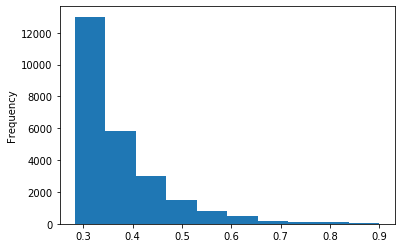

In [75]:
merged_df["neg"].plot(kind="hist")

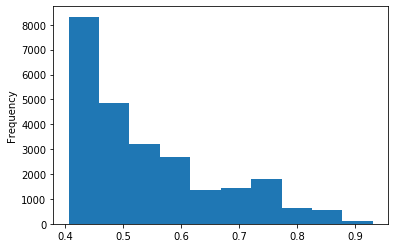

In [76]:
merged_df["pos"].plot(kind="hist")

In [85]:
count = 0
merged_df.sort_values(by="pos", ascending=False)

,id,pos,by,time,text,parent,neg
1189991,22144530.0,0.931,NaN,NaN,NaN,NaN,NaN
130619,21084689.0,0.924,NaN,NaN,NaN,NaN,NaN
478487,21432724.0,0.923,NaN,NaN,NaN,NaN,NaN
1158457,22112986.0,0.921,NaN,NaN,NaN,NaN,NaN
899937,21854352.0,0.921,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
881341,21070944.0,NaN,r1ch,1.569421e+09,Most likely so the receivers of abusive traffi...,21070846.0,0.283
808932,20986342.0,NaN,luckylion,1.568654e+09,&gt; Here you are complaining about a lack of ...,20986256.0,0.283
918083,21113756.0,NaN,fugly_nerd,1.569841e+09,Seriously I feel so attacked right now. Barrin...,21113605.0,0.283
899295,21091919.0,NaN,jkepler,1.569592e+09,"Plus, haven&#x27;t governments massacred milli...",21091625.0,0.283


In [97]:
count = 0
for _, (idx, pos, text) in pos_df[["id", "pos", "text"]].iterrows():
    print(text)
    count += 1
    if count > 40:
        break

That&#x27;s also true of type safety, and every other technique...
this seems awesome.
Thanks, seeing that atomic fetch in action is very useful.
I&#x27;m sure the Ontario line will be a great success... &#x2F;s
Thanks glad you like it, I am having some fun as well as people join and make noises. Whistling is something people like to do. Maybe start a whistle channel :)
fun fact :+1:
Interested in this one.
Ah I didn&#x27;t know that. Thanks.
&gt; If you play standard, it&#x27;s definitely pay-to-win.<p>Yes, but casual games with friends can be really enjoyable. 
 Sealed events at the LGS are good too.
Thanks, i completely missed that part. Very interesting solution...
Super awesome. I just tried Obama&#x27;s inaugural speech as Linkedin Icon - <a href="https:&#x2F;&#x2F;github.com&#x2F;amrrs&#x2F;stylecloud-demo&#x2F;blob&#x2F;master&#x2F;obama_speech_linkedin.PNG" rel="nofollow">https:&#x2F;&#x2F;github.com&#x2F;amrrs&#x2F;stylecloud-demo&#x2F;blob&#x2F;master&#x2F;obama_s...</a> It 